<a href="https://colab.research.google.com/github/TiagoPhys/dataset_ml_discipline/blob/main/House_Rent_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as srn
import statistics as sts
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [2]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 34 kB/s 


In [3]:
from scipy.stats import probplot, boxcox
from scipy.special import inv_boxcox
import pylab

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf

In [4]:
dataset = pd.read_csv("House_Rent_Dataset.csv")
dataset.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [ ]:
print(f'Number of rows in the dataset: {dataset.shape[0]}')
print(f'Number of columns in the dataset: {dataset.shape[1]}')

Number of rows in the dataset: 4746
Number of columns in the dataset: 12


In [ ]:
dataset['Posted On'] = pd.to_datetime(dataset['Posted On'])

In [ ]:
dataset.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


Here we note that the Mean Rent is greater than twice of Median Rent, so there are some outliers in this column

**Checking for missing values**

In [ ]:
dataset.isna().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

**Checking the distribution of Rent**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Rent')

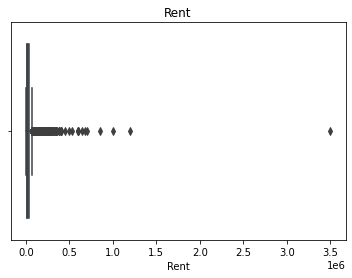

In [ ]:
srn.boxplot(dataset['Rent']).set_title('Rent')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Rent')

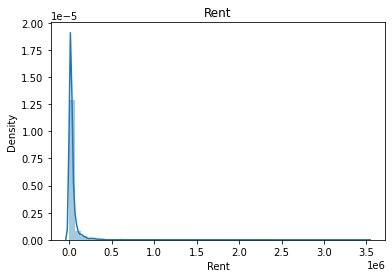

In [ ]:
srn.distplot(dataset['Rent']).set_title('Rent')

In [ ]:
desv = sts.stdev(dataset['Rent'])
desv

78106.4129373483

In [ ]:
dataset.loc[dataset['Rent'] >= 2*desv]

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
104,2022-06-16,2,180000,950,Ground out of 1,Carpet Area,"Avenue S, Santoshpur",Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
530,2022-06-20,2,160000,800,14 out of 14,Carpet Area,parivar safalya chs,Mumbai,Unfurnished,Bachelors/Family,2,Contact Owner
531,2022-07-07,4,300000,1600,43 out of 78,Carpet Area,"Trump Tower, Worli",Mumbai,Semi-Furnished,Bachelors/Family,5,Contact Agent
542,2022-06-21,3,270000,1800,3 out of 7,Carpet Area,Bandra West,Mumbai,Semi-Furnished,Bachelors/Family,4,Contact Agent
543,2022-07-04,5,400000,2308,17 out of 31,Carpet Area,"Runwal Elegante, Andheri West",Mumbai,Furnished,Family,5,Contact Agent
...,...,...,...,...,...,...,...,...,...,...,...,...
3879,2022-06-30,4,250000,4500,Ground out of 2,Carpet Area,Jubilee Hills,Hyderabad,Semi-Furnished,Family,4,Contact Agent
3989,2022-07-02,5,300000,4050,Ground out of 5,Super Area,"Bandlaguda Jagir,, Hyderabad",Hyderabad,Unfurnished,Bachelors/Family,4,Contact Owner
4185,2022-06-06,1,200000,8000,Ground out of 4,Super Area,"Beeramguda, Ramachandra Puram, NH 9",Hyderabad,Unfurnished,Bachelors/Family,10,Contact Owner
4457,2022-07-06,4,400000,7000,Lower Basement out of 2,Carpet Area,Jubilee Hills,Hyderabad,Semi-Furnished,Bachelors/Family,6,Contact Agent


In [ ]:
mediana = sts.median(dataset['Rent'])
mediana

16000.0

**Replacement of outliers by the median** 

In [ ]:
dataset.loc[dataset['Rent'] >= 2*desv, 'Rent'] = mediana

In [ ]:
dataset.loc[dataset['Rent'] >= 2*desv]

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact


**Rechecking the Rent distribution after eliminating outliers**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Rent')

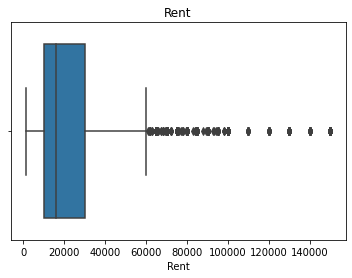

In [ ]:
srn.boxplot(dataset['Rent']).set_title('Rent')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Rent')

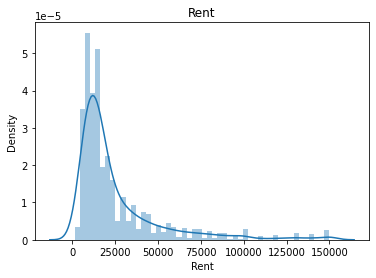

In [ ]:
srn.distplot(dataset['Rent']).set_title('Rent')

**Checking the distribution of Size**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Size')

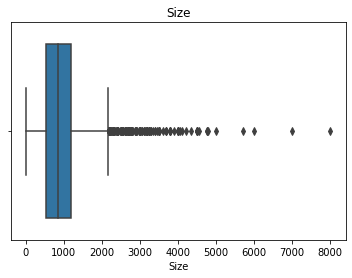

In [ ]:
srn.boxplot(dataset['Size']).set_title('Size')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Size')

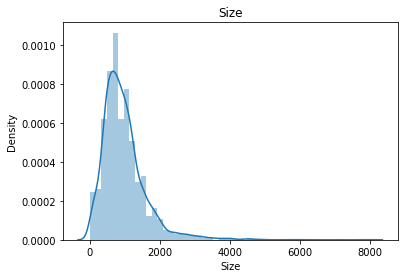

In [ ]:
srn.distplot(dataset['Size']).set_title('Size')

In [ ]:
desv = sts.stdev(dataset['Size'])
desv

634.2023275120672

In [ ]:
dataset.loc[dataset['Size'] >= 2*desv]

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
15,2022-06-01,3,40000,1286,1 out of 1,Carpet Area,New Town Action Area 1,Kolkata,Furnished,Bachelors/Family,2,Contact Owner
18,2022-06-09,2,11000,2000,Ground out of 3,Carpet Area,Behala Chowrasta,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
23,2022-06-15,3,6500,1600,Ground out of 2,Super Area,Joka,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
41,2022-05-12,3,12000,1500,Ground out of 2,Carpet Area,Bhadrakali,Kolkata,Furnished,Bachelors,2,Contact Owner
45,2022-06-06,2,10000,1300,Ground out of 1,Super Area,Kalikapur,Kolkata,Semi-Furnished,Family,2,Contact Owner
...,...,...,...,...,...,...,...,...,...,...,...,...
4737,2022-07-07,3,15000,1500,Lower Basement out of 2,Super Area,Almasguda,Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
4740,2022-06-02,2,12000,1350,2 out of 2,Super Area,Old Alwal,Hyderabad,Unfurnished,Bachelors/Family,2,Contact Owner
4742,2022-05-15,3,29000,2000,1 out of 4,Super Area,"Manikonda, Hyderabad",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
4743,2022-07-10,3,35000,1750,3 out of 5,Carpet Area,"Himayath Nagar, NH 7",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Agent


In [ ]:
mediana = sts.median(dataset['Size'])
mediana

850.0

In [ ]:
dataset.loc[dataset['Size'] >= 2*desv, 'Size'] = mediana

In [ ]:
dataset.loc[dataset['Size'] >= 2*desv]

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact


**Rechecking the Size distribution after eliminating outliers**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Size')

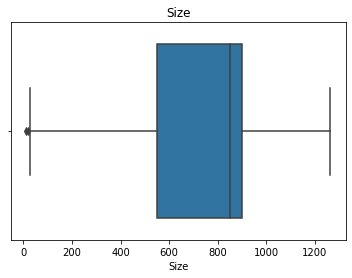

In [ ]:
srn.boxplot(dataset['Size']).set_title('Size')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Size')

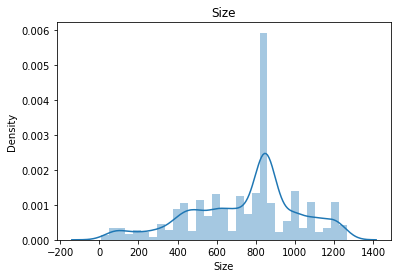

In [ ]:
srn.distplot(dataset['Size']).set_title('Size')

**Plotting categorical variables vs Rent**

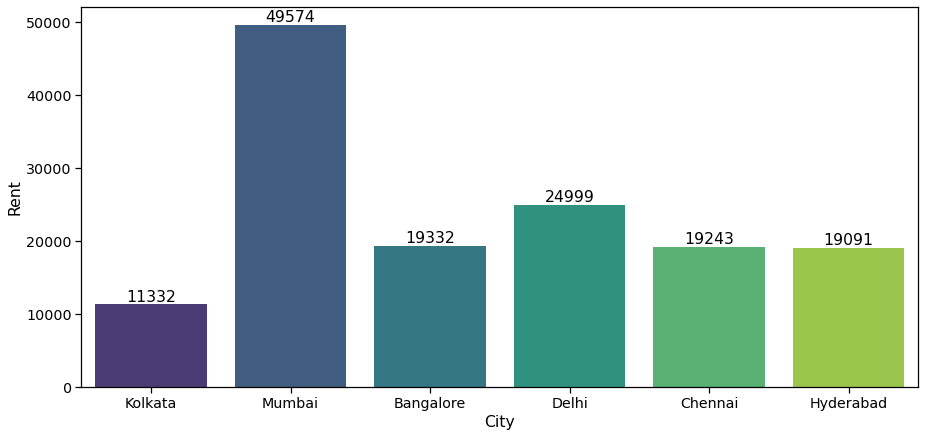

In [ ]:
srn.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 7))
ax = srn.barplot(x=dataset['City'], 
                 y=dataset['Rent'], 
                 palette='viridis',
                 ci = None)
plt.ylabel('Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

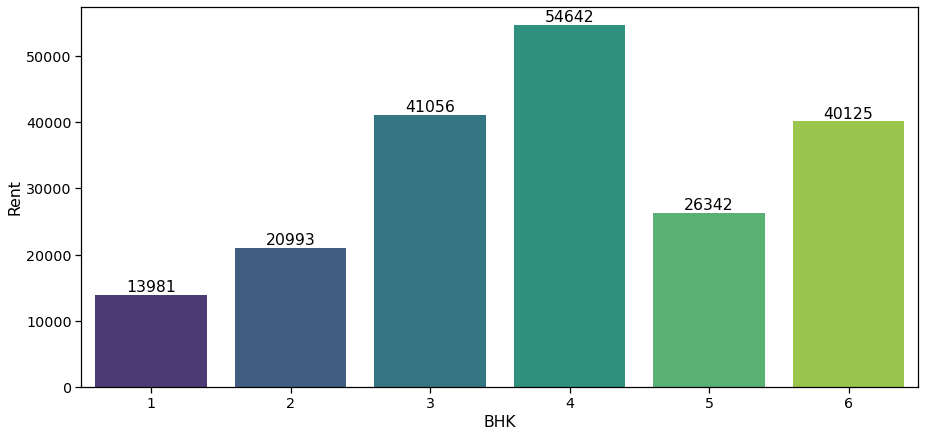

In [ ]:
srn.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 7))
ax = srn.barplot(x=dataset['BHK'].sort_values(ascending=True), 
                 y=dataset['Rent'], 
                 palette='viridis',
                 ci = None)
plt.ylabel('Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

In [ ]:
agrupado = dataset.groupby(['City']).size()
agrupado

City
Bangalore    886
Chennai      891
Delhi        605
Hyderabad    868
Kolkata      524
Mumbai       972
dtype: int64

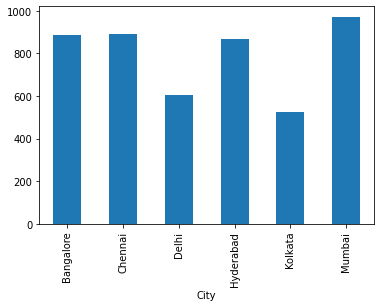

In [ ]:
agrupado.plot.bar()

In [ ]:
agrupado = dataset.groupby(['Area Type']).size()
agrupado

Area Type
Built Area        2
Carpet Area    2298
Super Area     2446
dtype: int64

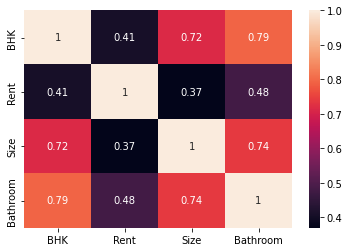

In [ ]:
dk=dataset.corr()
dk
srn.heatmap(dk,annot=True,)

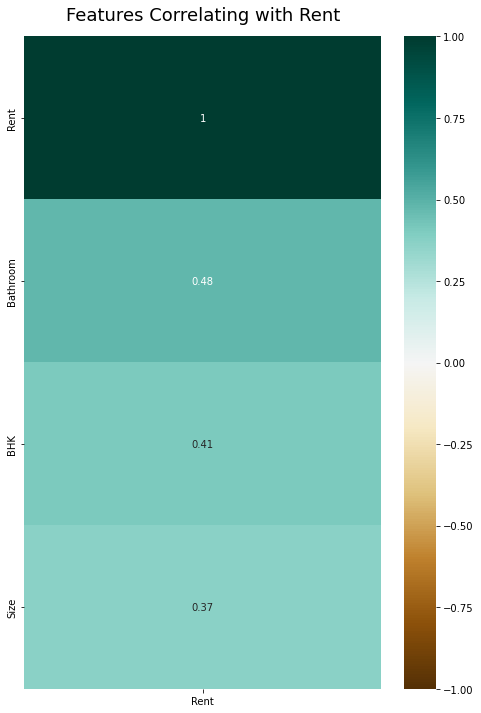

In [ ]:
dataset.corr()[['Rent']].sort_values(by='Rent', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = srn.heatmap(dataset.corr()[['Rent']].sort_values(by='Rent', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Rent', fontdict={'fontsize':18}, pad=16);

In [ ]:
px.scatter(dataset,y='Rent',x='Bathroom')

**Feature Engineering**

In [ ]:
dataset = dataset.join(dataset['Floor'].str.split(' out of ', 1, expand=True).rename(columns={0:'Floor Level', 1:'Total Floors'}))
dataset['Floor Level'] = dataset.apply(lambda x: 0 if x['Floor Level'] =='Ground' \
                                 else ( -1 if x['Floor Level'] =='Lower Basement' else (x['Total Floors']) ) , axis=1)

dataset.drop('Floor', axis=1, inplace=True)
dataset = dataset.dropna()
dataset['Floor Level'] = dataset['Floor Level'].astype(int)
dataset['Total Floors'] = dataset['Total Floors'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
print(dataset['Point of Contact'].value_counts())
print()
print(dataset['Area Type'].value_counts())

Contact Owner      3212
Contact Agent      1529
Contact Builder       1
Name: Point of Contact, dtype: int64

Super Area     2444
Carpet Area    2296
Built Area        2
Name: Area Type, dtype: int64


In [ ]:
dataset = dataset[~dataset['Point of Contact'].str.contains("Contact Builder")]

In [ ]:
dataset['month posted'] = dataset['Posted On'].dt.month
dataset['day posted'] = dataset['Posted On'].dt.day
dataset['day of week posted'] = dataset['Posted On'].dt.day_of_week
dataset['quarter poster'] = dataset['Posted On'].dt.quarter

dataset.drop('Posted On', axis = 1, inplace= True)

**Encoding**

In [ ]:
print(dataset.duplicated().sum())
dataset = dataset.drop_duplicates()

8


In [ ]:
def one_hot_encode(dataset, column):
    encoded = pd.get_dummies(dataset[column], drop_first= True)
    dataset = dataset.drop(column, axis = 1)
    dataset = dataset.join(encoded)
    return dataset

In [ ]:
dataset = dataset.drop('Area Locality', axis= 1)

In [ ]:
columns = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']
for col in columns:
    dataset = one_hot_encode(dataset, col)

In [ ]:
dataset.head()

,BHK,Rent,Size,Bathroom,Floor Level,Total Floors,month posted,day posted,day of week posted,quarter poster,...,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Semi-Furnished,Unfurnished,Bachelors/Family,Family,Contact Owner
0,2,10000,1100,2,0,2,5,18,2,2,...,0,0,0,1,0,0,1,1,0,1
1,2,20000,800,1,3,3,5,13,4,2,...,0,0,0,1,0,1,0,1,0,1
2,2,17000,1000,1,3,3,5,16,0,2,...,0,0,0,1,0,1,0,1,0,1
3,2,10000,800,1,2,2,7,4,0,3,...,0,0,0,1,0,0,1,1,0,1
4,2,7500,850,1,2,2,5,9,0,2,...,0,0,0,1,0,0,1,0,0,1


In [ ]:
X = dataset.drop('Rent', axis= 1)
y = dataset['Rent']

bc_result = scipy.stats.boxcox(y)
y_boxcox = bc_result[0]
lambda_ = bc_result[1]

X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size= 0.2, random_state = 42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
models = {
    'ridge' : Ridge(),
    'xgboost' : XGBRegressor(),
    'catboost' : CatBoostRegressor(verbose=0),
    'lightgbm' : LGBMRegressor(),
    'gradient boosting' : GradientBoostingRegressor(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'bayesian ridge' : BayesianRidge(),
    'support vector': SVR(),
    'knn' : KNeighborsRegressor(n_neighbors = 4)
}

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')

ridge trained
[18:24:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost trained
catboost trained
lightgbm trained
gradient boosting trained
lasso trained
random forest trained
bayesian ridge trained
support vector trained
knn trained


In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(20))
model.add(tf.keras.layers.Dense(60))
model.add(tf.keras.layers.Dense(60))
model.add(tf.keras.layers.Dense(60))
model.add(tf.keras.layers.Dense(1))

model.compile(
    loss = 'mse', 
    optimizer = tf.keras.optimizers.Adam(), 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
119/119 [==============================] - 2s 5ms/step - loss: 3.4791 - rmse: 1.8652 - val_loss: 0.0182 - val_rmse: 0.1351
Epoch 2/5
119/119 [==============================] - 0s 3ms/step - loss: 0.0069 - rmse: 0.0833 - val_loss: 0.0029 - val_rmse: 0.0535
Epoch 3/5
119/119 [==============================] - 0s 3ms/step - loss: 0.0024 - rmse: 0.0494 - val_loss: 0.0017 - val_rmse: 0.0415
Epoch 4/5
119/119 [==============================] - 0s 3ms/step - loss: 0.0021 - rmse: 0.0459 - val_loss: 0.0023 - val_rmse: 0.0480
Epoch 5/5
119/119 [==============================] - 0s 3ms/step - loss: 0.0026 - rmse: 0.0513 - val_loss: 0.0018 - val_rmse: 0.0421


In [ ]:
RMSE_ann = model.evaluate(X_test, y_test)[1]
RMSE_ann

30/30 [==============================] - 0s 3ms/step - loss: 0.0018 - rmse: 0.0421


0.04209326580166817

In [ ]:
results = {}
kf = KFold(n_splits= 10)

for name, model in models.items():
    result = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', cv= kf)))
    results[name] = result
    
results['ANN'] = RMSE_ann


[18:25:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:25:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
for name, result in results.items():
    print(f"{name} : {round(result, 3)}")

ridge : 0.036
xgboost : 0.031
catboost : 0.03
lightgbm : 0.031
gradient boosting : 0.031
lasso : 0.057
random forest : 0.032
bayesian ridge : 0.036
support vector : 0.042
knn : 0.035
ANN : 0.042


In [ ]:
results_df = pd.DataFrame(results, index=range(0,1)).T.rename(columns={0: 'RMSE'}).sort_values('RMSE', ascending=False)
results_df.T

,lasso,ANN,support vector,ridge,bayesian ridge,knn,random forest,xgboost,gradient boosting,lightgbm,catboost
RMSE,0.057118,0.042093,0.041917,0.035899,0.035898,0.035202,0.031638,0.030984,0.0308,0.030673,0.030389


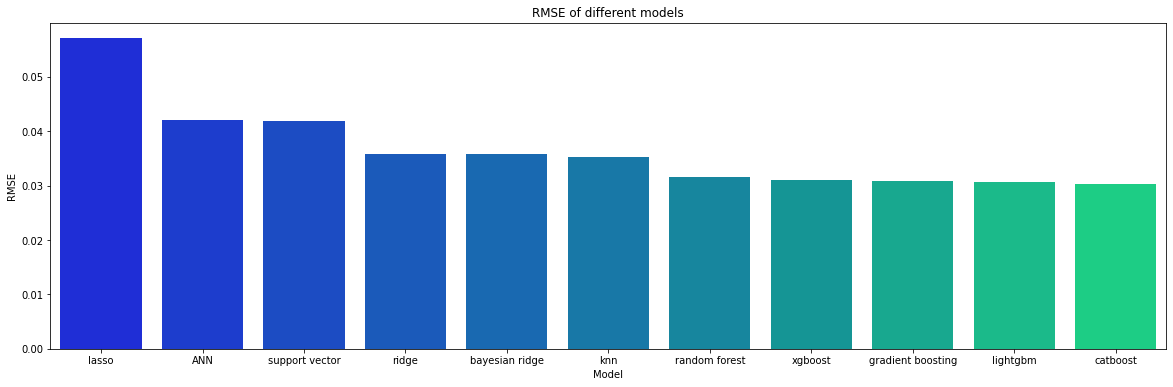

In [ ]:
plt.figure(figsize = (20, 6))
srn.barplot(x= results_df.index, y = results_df['RMSE'], palette = 'winter')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of different models');